In [1]:
from __future__ import annotations

import argparse
import importlib

import hist
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
import xgboost as xgb

from HH4b import hh_vars, plotting, postprocessing, run_utils
from HH4b.hh_vars import (
    bg_keys,
    mreg_strings,
    samples_run3,
    ttbarsfs_decorr_ggfbdt_bins,
    ttbarsfs_decorr_txbb_bins,
    ttbarsfs_decorr_vbfbdt_bins,
    txbb_strings,
    txbbsfs_decorr_pt_bins,
    txbbsfs_decorr_txbb_wps,
)
from HH4b.postprocessing import (
    Region,
    combine_run3_samples,
    corrections,
    get_weight_shifts,
    load_run3_samples,
)
from HH4b.utils import (
    ShapeVar,
    check_get_jec_var,
    discretize_var,
    get_var_mapping,
    singleVarHist,
)

from HH4b.postprocessing.PostProcess import load_process_run3_samples

mass_axis = hist.axis.Regular(16, 60, 220, name="mass")
bdt_bins = 100
bdt_axis = hist.axis.Regular(bdt_bins, 0, 1, name="bdt")
xbb_bins = 100
xbb_axis = hist.axis.Regular(xbb_bins, 0, 1, name="xbb")
diff_axis = hist.axis.Regular(50, -2, 2, name="diff")

In [2]:
def get_toy_from_hist(h_hist, n_samples, rng):
    """
    Get random values drawn from histogram
    """
    h, bins = h_hist.to_numpy()

    bin_midpoints = bins[:-1] + np.diff(bins) / 2
    cdf = np.cumsum(h)
    cdf = cdf / cdf[-1]
    values = rng.random(n_samples)  # noqa: NPY002
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]
    return random_from_cdf


def get_toy_from_3d_hist(h_hist, n_samples, rng):
    """
    Get random values drawn from histogram
    """
    h, x_bins, y_bins, z_bins = h_hist.to_numpy()

    x_bin_midpoints = x_bins[:-1] + np.diff(x_bins) / 2
    y_bin_midpoints = y_bins[:-1] + np.diff(y_bins) / 2
    z_bin_midpoints = z_bins[:-1] + np.diff(z_bins) / 2
    cdf = np.cumsum(h.ravel())
    cdf = cdf / cdf[-1]
    values = rng.random(n_samples)  # noqa: NPY002
    value_bins = np.searchsorted(cdf, values)
    x_idx, y_idx, z_idx = np.unravel_index(
        value_bins, (len(x_bin_midpoints), len(y_bin_midpoints), len(z_bin_midpoints))
    )
    random_from_cdf = np.column_stack(
        (x_bin_midpoints[x_idx], y_bin_midpoints[y_idx], z_bin_midpoints[z_idx])
    )

    return random_from_cdf

In [3]:
from argparse import Namespace

args = Namespace(
    templates_tag="25June2ReRunBDTZbbSFs384Check",
    data_dir="/ceph/cms/store/user/dprimosc/bbbb/skimmer/",
    mass_bins=10,
    tag="25May9_v12v2_private_signal",
    years=["2022", "2022EE", "2023", "2023BPix"],
    training_years=None,
    mass="H2PNetMass",
    bdt_model="25Feb5_v13_glopartv2_rawmass",
    bdt_config="v13_glopartv2",
    txbb="glopart-v2",
    txbb_wps=[0.945, 0.85],
    bdt_wps=[0.94, 0.755, 0.03],
    method="abcd",
    vbf_txbb_wp=0.8,
    vbf_bdt_wp=0.9825,
    weight_ttbar_bdt=1.0,
    # sig_keys=['hh4b', 'hh4b-kl0', 'hh4b-kl2p45', 'hh4b-kl5', 'vbfhh4b', 'vbfhh4b-k2v0', 'vbfhh4b-kv1p74-k2v1p37-kl14p4', 'vbfhh4b-kvm0p012-k2v0p03-kl10p2', 'vbfhh4b-kvm0p758-k2v1p44-klm19p3', 'vbfhh4b-kvm0p962-k2v0p959-klm1p43', 'vbfhh4b-kvm1p21-k2v1p94-klm0p94', 'vbfhh4b-kvm1p6-k2v2p72-klm1p36', 'vbfhh4b-kvm1p83-k2v3p57-klm3p39', 'vbfhh4b-kvm2p12-k2v3p87-klm5p96'],
    sig_keys=["hh4b"],
    pt_first=300.0,
    pt_second=250.0,
    fom_vbf_samples=["vbfhh4b-k2v0"],
    fom_ggf_samples=["hh4b"],
    bdt_disc=True,
    event_list=False,
    event_list_dir="event_lists",
    bdt_roc=False,
    control_plots=False,
    fom_scan=False,
    fom_scan_bin1=True,
    fom_scan_bin2=True,
    fom_scan_vbf=False,
    templates=False,
    vbf=True,
    vbf_priority=False,
    correct_vbf_bdt_shape=True,
    blind=True,
    rerun_inference=True,
    scale_smear=False,
    dummy_txbb_sfs=False,
)

In [4]:
fom_window_by_mass = {"H2PNetMass": [110, 155]}
blind_window_by_mass = {"H2PNetMass": [110, 140]}
mass_window = np.array(fom_window_by_mass[args.mass])
n_mass_bins = int((220 - 60) / args.mass_bins)

In [5]:
events_dict_postprocess = {}
cutflows = {}
from pathlib import Path

# modify samples run3
for year in samples_run3:
    samples_run3[year]["qcd"] = [
        "QCD_HT-1000to1200",
        "QCD_HT-1200to1500",
        "QCD_HT-1500to2000",
        "QCD_HT-2000",
        # "QCD_HT-200to400",
        "QCD_HT-400to600",
        "QCD_HT-600to800",
        "QCD_HT-800to1000",
    ]
    for key in list(samples_run3[year]):
        if "hh4b" in key and key != "hh4b":
            del samples_run3[year][key]
    print(samples_run3[year])

# get top-level HH4b directory
HH4B_DIR = "/home/users/woodson/HH4b/"
plot_dir = Path(f"{HH4B_DIR}/plots/PostProcess/{args.templates_tag}")
plot_dir.mkdir(exist_ok=True, parents=True)
for year in args.years:
    print(f"\n{year}")
    events, cutflow = load_process_run3_samples(
        args,
        year,
        [],
        args.control_plots,
        plot_dir,
        mass_window,
        args.rerun_inference,
    )
    events_dict_postprocess[year] = events
    cutflows[year] = cutflow

[2025-06-18 21:06:09,231] INFO: HH4b.postprocessing.PostProcess Load samples data


{'qcd': ['QCD_HT-1000to1200', 'QCD_HT-1200to1500', 'QCD_HT-1500to2000', 'QCD_HT-2000', 'QCD_HT-400to600', 'QCD_HT-600to800', 'QCD_HT-800to1000'], 'data': ['JetMET_Run', 'Muon_Run', 'EGamma_Run'], 'ttbar': ['TTto4Q', 'TTto2L2Nu', 'TTtoLNu2Q'], 'vhtobb': ['WplusH_Hto2B_Wto2Q_M-125', 'WminusH_Hto2B_Wto2Q_M-125', 'ZH_Hto2B_Zto2Q_M-125', 'ggZH_Hto2B_Zto2Q_M-125'], 'novhhtobb': ['GluGluHto2B_PT-200_M-125', 'VBFHto2B_M-125_dipoleRecoilOn'], 'tthtobb': ['ttHto2B_M-125'], 'zz': ['ZZ'], 'nozzdiboson': ['WW', 'WZ'], 'vjets': ['Wto2Q-2Jets_PTQQ', 'Zto2Q-2Jets_PTQQ'], 'hh4b': ['GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?']}
{'qcd': ['QCD_HT-1000to1200', 'QCD_HT-1200to1500', 'QCD_HT-1500to2000', 'QCD_HT-2000', 'QCD_HT-400to600', 'QCD_HT-600to800', 'QCD_HT-800to1000'], 'data': ['JetMET_Run', 'Muon_Run', 'EGamma_Run'], 'ttbar': ['TTto4Q', 'TTto2L2Nu', 'TTtoLNu2Q'], 'vhtobb': ['WplusH_Hto2B_Wto2Q_M-125', 'WminusH_Hto2B_Wto2Q_M-125', 'ZH_Hto2B_Zto2Q_M-125', 'ggZH_Hto2B_Zto2Q_M-125'], 'novhht

[2025-06-18 21:06:36,779] INFO: HH4b.utils           Loaded JetMET_Run2022D                                   : 1711715 entries
[2025-06-18 21:06:48,110] INFO: HH4b.utils           Loaded JetMET_Run2022C_single                            : 310669 entries
[2025-06-18 21:07:41,201] INFO: HH4b.utils           Loaded JetMET_Run2022C                                   : 2740272 entries
[2025-06-18 21:07:41,494] INFO: HH4b.postprocessing.PostProcess JEC shifts ['']
[2025-06-18 21:07:41,495] INFO: HH4b.postprocessing.PostProcess Perform inference
[2025-06-18 21:07:54,377] INFO: HH4b.postprocessing.PostProcess Inference and selection for jshift 
[2025-06-18 21:07:54,554] INFO: HH4b.postprocessing.PostProcess Data cutflow in [110-155] is taken from sideband estimate!
[2025-06-18 21:07:54,560] INFO: HH4b.postprocessing.PostProcess Load samples ttbar
[2025-06-18 21:08:20,593] INFO: HH4b.utils           Loaded TTto2L2Nu                                         : 83648 entries
[2025-06-18 21:10:04,70


2022EE


[2025-06-18 21:26:45,830] INFO: HH4b.utils           Loaded JetMET_Run2022G                                   : 2016716 entries
[2025-06-18 21:29:06,357] INFO: HH4b.utils           Loaded JetMET_Run2022F                                   : 13012684 entries
[2025-06-18 21:29:53,946] INFO: HH4b.utils           Loaded JetMET_Run2022E                                   : 3223048 entries
[2025-06-18 21:29:54,957] INFO: HH4b.postprocessing.PostProcess JEC shifts ['']
[2025-06-18 21:29:54,958] INFO: HH4b.postprocessing.PostProcess Perform inference
[2025-06-18 21:30:35,792] INFO: HH4b.postprocessing.PostProcess Inference and selection for jshift 
[2025-06-18 21:30:36,364] INFO: HH4b.postprocessing.PostProcess Data cutflow in [110-155] is taken from sideband estimate!
[2025-06-18 21:30:36,376] INFO: HH4b.postprocessing.PostProcess Load samples ttbar
[2025-06-18 21:31:00,409] INFO: HH4b.utils           Loaded TTto2L2Nu                                         : 175444 entries
[2025-06-18 21:33:45


2023


[2025-06-18 21:50:48,278] INFO: HH4b.utils           Loaded JetMET_Run2023Cv1                                 : 2742397 entries
[2025-06-18 21:52:39,882] INFO: HH4b.utils           Loaded JetMET_Run2023Cv4                                 : 5100873 entries
[2025-06-18 21:52:54,099] INFO: HH4b.utils           Loaded JetMET_Run2023Cv2                                 : 836714 entries
[2025-06-18 21:53:07,559] INFO: HH4b.utils           Loaded JetMET_Run2023Cv3                                 : 717861 entries
[2025-06-18 21:53:08,158] INFO: HH4b.postprocessing.PostProcess JEC shifts ['']
[2025-06-18 21:53:08,159] INFO: HH4b.postprocessing.PostProcess Perform inference
[2025-06-18 21:53:29,717] INFO: HH4b.postprocessing.PostProcess Inference and selection for jshift 
[2025-06-18 21:53:30,117] INFO: HH4b.postprocessing.PostProcess Data cutflow in [110-155] is taken from sideband estimate!
[2025-06-18 21:53:30,124] INFO: HH4b.postprocessing.PostProcess Load samples ttbar
[2025-06-18 21:53:46,6


2023BPix


[2025-06-18 22:06:41,621] INFO: HH4b.utils           Loaded JetMET_Run2023D                                   : 4149633 entries
[2025-06-18 22:06:41,826] INFO: HH4b.postprocessing.PostProcess JEC shifts ['']
[2025-06-18 22:06:41,827] INFO: HH4b.postprocessing.PostProcess Perform inference
[2025-06-18 22:06:51,116] INFO: HH4b.postprocessing.PostProcess Inference and selection for jshift 
[2025-06-18 22:06:51,296] INFO: HH4b.postprocessing.PostProcess Data cutflow in [110-155] is taken from sideband estimate!
[2025-06-18 22:06:51,301] INFO: HH4b.postprocessing.PostProcess Load samples ttbar
[2025-06-18 22:07:06,478] INFO: HH4b.utils           Loaded TTto2L2Nu                                         : 51364 entries
[2025-06-18 22:07:52,494] INFO: HH4b.utils           Loaded TTto4Q                                            : 1166729 entries
[2025-06-18 22:08:32,292] INFO: HH4b.utils           Loaded TTtoLNu2Q                                         : 536482 entries
[2025-06-18 22:08:32,51

In [6]:
processes = ["data"] + args.sig_keys + bg_keys
bg_keys_combined = bg_keys.copy()
if not args.control_plots and not args.bdt_roc:
    if "qcd" in processes:
        processes.remove("qcd")
    if "qcd" in bg_keys:
        bg_keys.remove("qcd")
    if "qcd" in bg_keys_combined:
        bg_keys_combined.remove("qcd")

if len(args.years) > 1:
    # list of years available for a given process to scale to full lumi,
    scaled_by_years = {
        # "zz": ["2022", "2022EE", "2023"],
    }
    events_combined, scaled_by = combine_run3_samples(
        events_dict_postprocess,
        processes,
        bg_keys=bg_keys_combined,
        scale_processes=scaled_by_years,
        years_run3=args.years,
    )
    print("Combined years")
else:
    events_combined = events_dict_postprocess[args.years[0]]
    scaled_by = {}

Combined years


In [7]:
# sample toys from product of 3 1D distributions
h_mass = hist.Hist(mass_axis)
h_mass.fill(events_combined["data"]["H2PNetMass"])
h_xbb = hist.Hist(xbb_axis)
h_xbb.fill(events_combined["data"]["H2TXbb"])
h_bdt = hist.Hist(bdt_axis)
h_bdt.fill(events_combined["data"]["bdt_score"])

# sample toys from 3D distribution
h_mass_xbb_bdt = hist.Hist(mass_axis, xbb_axis, bdt_axis)
h_mass_xbb_bdt.fill(
    mass=events_combined["data"]["H2PNetMass"],
    xbb=events_combined["data"]["H2TXbb"],
    bdt=events_combined["data"]["bdt_score"],
)

# make 2D histograms
h_mass_xbb = hist.Hist(mass_axis, xbb_axis)
h_mass_xbb.fill(
    mass=events_combined["data"]["H2PNetMass"],
    xbb=events_combined["data"]["H2TXbb"],
)
h_mass_bdt = hist.Hist(mass_axis, bdt_axis)
h_mass_bdt.fill(
    mass=events_combined["data"]["H2PNetMass"],
    bdt=events_combined["data"]["bdt_score"],
)
h_xbb_bdt = hist.Hist(xbb_axis, bdt_axis)
h_xbb_bdt.fill(
    xbb=events_combined["data"]["H2TXbb"],
    bdt=events_combined["data"]["bdt_score"],
)


integral = np.sum(h_mass_xbb_bdt.values())

print(f"Mean number of background events to draw from data: {integral}")

Mean number of background events to draw from data: 2049200.0


In [8]:
# plot 1D distributions
import matplotlib as mpl


def plot_corner(h_mass, h_xbb, h_bdt, h_mass_xbb, h_mass_bdt, h_xbb_bdt):
    fig, ax = plt.subplots(3, 3, figsize=(20, 20))
    hep.histplot(h_mass, ax=ax[0, 0])
    hep.histplot(h_xbb, ax=ax[1, 1])
    hep.histplot(h_bdt, ax=ax[2, 2])
    ax[0, 0].set_xlim(60, 220)
    ax[1, 1].set_xlim(0, 1)
    ax[2, 2].set_xlim(0, 1)
    ax[1, 1].set_yscale("log")
    ax[2, 2].set_yscale("log")
    hep.hist2dplot(h_mass_xbb, ax=ax[1, 0], norm=mpl.colors.LogNorm())
    hep.hist2dplot(h_mass_bdt, ax=ax[2, 0], norm=mpl.colors.LogNorm())
    hep.hist2dplot(h_xbb_bdt, ax=ax[2, 1], norm=mpl.colors.LogNorm())
    ax[0, 1].axis("off")
    ax[0, 2].axis("off")
    ax[1, 2].axis("off")
    # tight layout
    plt.tight_layout()
    fig.show()
    plt.savefig("corners.pdf", bbox_inches="tight")
    return fig


plot_corner(h_mass, h_xbb, h_bdt, h_mass_xbb, h_mass_bdt, h_xbb_bdt)

In [9]:
from typing import Callable
from HH4b.postprocessing.PostProcess import abcd, sideband, get_nevents_nosignal
import numba as nb


def scan_fom(
    method: str,
    events_combined: pd.DataFrame,
    get_cut: Callable,
    get_anti_cut: Callable,
    xbb_cuts: np.ArrayLike,
    bdt_cuts: np.ArrayLike,
    mass_window: list[float],
    bg_keys: list[str],
    sig_keys: list[str],
    fom: str = "2sqrt(b)/s",
    mass: str = "H2Msd",
):
    """Generic FoM scan for given region, defined in the ``get_cut`` function."""

    print(f"Scanning {fom} with {method}")
    all_s = []
    all_b = []
    all_sideband_events = []
    all_xbb_cuts = []
    all_bdt_cuts = []
    all_fom = []
    for xbb_cut in xbb_cuts:
        for bdt_cut in bdt_cuts:
            if method == "abcd":
                nevents_sig, nevents_bkg, _ = abcd(
                    events_combined,
                    get_cut,
                    get_anti_cut,
                    xbb_cut,
                    bdt_cut,
                    mass,
                    mass_window,
                    bg_keys,
                    sig_keys,
                )
            else:
                nevents_sig, nevents_bkg, _ = sideband(
                    events_combined, get_cut, xbb_cut, bdt_cut, mass, mass_window, sig_keys
                )

            # number of events in data in sideband
            cut = get_cut(events_combined["data"], xbb_cut, bdt_cut)
            nevents_sideband = get_nevents_nosignal(events_combined["data"], cut, mass, mass_window)

            if fom == "s/sqrt(s+b)":
                if nevents_sig + nevents_bkg > 0:
                    figure_of_merit = nevents_sig / np.sqrt(nevents_sig + nevents_bkg)
                else:
                    figure_of_merit = np.nan
            elif fom == "2sqrt(b)/s":
                if nevents_bkg > 0 and nevents_sig > 0:
                    figure_of_merit = 2 * np.sqrt(nevents_bkg) / nevents_sig
                else:
                    figure_of_merit = np.nan
            else:
                raise ValueError("Invalid FOM")

            all_b.append(nevents_bkg)
            all_s.append(nevents_sig)
            all_sideband_events.append(nevents_sideband)
            all_xbb_cuts.append(xbb_cut)
            all_bdt_cuts.append(bdt_cut)
            all_fom.append(figure_of_merit)

    all_fom = np.array(all_fom)
    all_b = np.array(all_b)
    all_s = np.array(all_s)
    all_sideband_events = np.array(all_sideband_events)
    all_xbb_cuts = np.array(all_xbb_cuts)
    all_bdt_cuts = np.array(all_bdt_cuts)

    return all_fom, all_b, all_s, all_sideband_events, all_xbb_cuts, all_bdt_cuts


def get_optimal_cuts(all_fom, all_b, all_s, all_sideband_events, all_xbb_cuts, all_bdt_cuts):

    bdt_cuts = np.sort(np.unique(all_bdt_cuts))
    xbb_cuts = np.sort(np.unique(all_xbb_cuts))

    h_sb = hist.Hist(
        hist.axis.Variable(list(bdt_cuts), name="bdt_cut"),
        hist.axis.Variable(list(xbb_cuts), name="xbb_cut"),
    )
    h_s = hist.Hist(
        hist.axis.Variable(list(bdt_cuts), name="bdt_cut"),
        hist.axis.Variable(list(xbb_cuts), name="xbb_cut"),
    )
    h_b = hist.Hist(
        hist.axis.Variable(list(bdt_cuts), name="bdt_cut"),
        hist.axis.Variable(list(xbb_cuts), name="xbb_cut"),
    )

    for xbb_cut in xbb_cuts:
        for bdt_cut in bdt_cuts:
            # find index of this cut
            idx = np.where((all_bdt_cuts == bdt_cut) & (all_xbb_cuts == xbb_cut))[0][0]
            if all_s[idx] > 0.5 and all_b[idx] >= 2 and all_sideband_events[idx] >= 12:
                h_sb.fill(bdt_cut, xbb_cut, weight=all_fom[idx])
                h_b.fill(bdt_cut, xbb_cut, weight=all_b[idx])
                h_s.fill(bdt_cut, xbb_cut, weight=all_s[idx])

    masked_h_sb = np.ma.masked_equal(h_sb.values(), 0)

    global_min = np.min(masked_h_sb)

    if np.ma.is_masked(global_min):
        return None, None, None, None, None, None

    masked_h_sb_min_diff = np.abs(masked_h_sb - global_min)

    argmin_axis0 = np.argmin(masked_h_sb_min_diff, axis=0)
    min_axis0 = np.min(masked_h_sb_min_diff, axis=0)

    argmin_axis1 = np.argmin(masked_h_sb_min_diff, axis=1)
    min_axis1 = np.min(masked_h_sb_min_diff, axis=1)

    bdt_cut = h_sb.axes[0].edges[argmin_axis0[min_axis0 == 0]][0]
    xbb_cut = h_sb.axes[1].edges[argmin_axis1[min_axis1 == 0]][0]

    b = h_b.values()[argmin_axis0[min_axis0 == 0], argmin_axis1[min_axis1 == 0]][0]
    s = h_s.values()[argmin_axis0[min_axis0 == 0], argmin_axis1[min_axis1 == 0]][0]

    return global_min, bdt_cut, xbb_cut, h_sb, b, s


def get_anti_cuts():

    def anti_cut_ggf(events):
        cut_xbb = events["H2TXbb"] < 0.3
        cut_bdt = events["bdt_score"] < 0.6
        return cut_xbb & cut_bdt

    return anti_cut_ggf


def get_cuts():

    # bin 1 region
    def get_cut_bin1(events, xbb_cut, bdt_cut):
        cut_xbb = events["H2TXbb"] > xbb_cut
        cut_bdt = events["bdt_score"] > bdt_cut
        return cut_xbb & cut_bdt

    return get_cut_bin1

In [10]:
def run_toys(ntoys, lumi_scale=1.0, use_3d_hist=True):

    bdt_cut_toys = []
    xbb_cut_toys = []
    s_toys = []
    b_toys = []
    fom_toys = []

    # get numpy generator for reproducibility
    rng = np.random.default_rng(42)

    for itoy in range(ntoys):
        n_samples = rng.poisson(integral * lumi_scale)  # noqa: NPY002

        if use_3d_hist:
            mass_xbb_bdt_toy = get_toy_from_3d_hist(h_mass_xbb_bdt, n_samples, rng)
            mass_toy = mass_xbb_bdt_toy[:, 0]
            xbb_toy = mass_xbb_bdt_toy[:, 1]
            bdt_toy = mass_xbb_bdt_toy[:, 2]
        else:
            mass_toy = get_toy_from_hist(h_mass, n_samples, rng)
            xbb_toy = get_toy_from_hist(h_xbb, n_samples, rng)
            bdt_toy = get_toy_from_hist(h_bdt, n_samples, rng)

        events_toy = {}
        for key in events_combined:
            if key != "data":
                events_toy[key] = events_combined[key][
                    ["H2PNetMass", "bdt_score", "H2TXbb", "weight"]
                ].copy()
                events_toy[key]["weight"] *= lumi_scale  # scale by lumi
            else:
                events_toy["data"] = pd.DataFrame(
                    {
                        "H2PNetMass": mass_toy,
                        "bdt_score": bdt_toy,
                        "H2TXbb": xbb_toy,
                        "weight": np.ones_like(mass_toy),
                    }
                )

        all_fom, all_b, all_s, all_sideband_events, all_xbb_cuts, all_bdt_cuts = scan_fom(
            args.method,
            events_toy,
            get_cuts(),
            get_anti_cuts(),
            np.arange(0.8, 0.999, 0.01),
            np.arange(0.8, 0.999, 0.01),
            mass_window,
            bg_keys=bg_keys,
            sig_keys=args.fom_ggf_samples,
            mass=args.mass,
        )

        global_min, bdt_cut, xbb_cut, h_sb, b, s = get_optimal_cuts(
            all_fom, all_b, all_s, all_sideband_events, all_xbb_cuts, all_bdt_cuts
        )
        if global_min is None:
            print(f"Skipping toy {itoy} due to no valid cuts found.")
            continue

        bdt_cut_toys.append(bdt_cut)
        xbb_cut_toys.append(xbb_cut)
        s_toys.append(s)
        b_toys.append(b)
        fom_toys.append(global_min)

        print(f"Toy: {itoy + 1}")
        print(f"Optimal cuts: bdt_cut={bdt_cut:.4f}, xbb_cut={xbb_cut:.4f}")
        print(
            f"2sqrt(b)/s={global_min:.4f}, b={b:.4f}, s={s:.4f}, s/b={s/b:.4f}, s/sqrt(b)={s/np.sqrt(b):.4f}"
        )

    return bdt_cut_toys, xbb_cut_toys, s_toys, b_toys, fom_toys

In [11]:
lumi_scale = 138.0 / 62.0
ntoys = 100
bdt_cut_toys, xbb_cut_toys, s_toys, b_toys, fom_toys = run_toys(
    ntoys, lumi_scale=lumi_scale, use_3d_hist=False
)

Scanning 2sqrt(b)/s with abcd
Toy: 1
Optimal cuts: bdt_cut=0.9000, xbb_cut=0.9100
2sqrt(b)/s=1.4760, b=4.5532, s=2.8913, s/b=0.6350, s/sqrt(b)=1.3550
Scanning 2sqrt(b)/s with abcd
Toy: 2
Optimal cuts: bdt_cut=0.9000, xbb_cut=0.9000
2sqrt(b)/s=1.4747, b=5.4236, s=3.1585, s/b=0.5824, s/sqrt(b)=1.3562
Scanning 2sqrt(b)/s with abcd
Toy: 3
Optimal cuts: bdt_cut=0.9200, xbb_cut=0.8800
2sqrt(b)/s=1.3794, b=5.7220, s=3.4683, s/b=0.6061, s/sqrt(b)=1.4499
Scanning 2sqrt(b)/s with abcd
Toy: 4
Optimal cuts: bdt_cut=0.9200, xbb_cut=0.8900
2sqrt(b)/s=1.4603, b=5.6573, s=3.2575, s/b=0.5758, s/sqrt(b)=1.3696
Scanning 2sqrt(b)/s with abcd
Toy: 5
Optimal cuts: bdt_cut=0.9200, xbb_cut=0.8900
2sqrt(b)/s=1.3738, b=5.0066, s=3.2575, s/b=0.6506, s/sqrt(b)=1.4558
Scanning 2sqrt(b)/s with abcd
Toy: 6
Optimal cuts: bdt_cut=0.9500, xbb_cut=0.8900
2sqrt(b)/s=1.5913, b=5.0754, s=2.8314, s/b=0.5579, s/sqrt(b)=1.2568
Scanning 2sqrt(b)/s with abcd
Toy: 7
Optimal cuts: bdt_cut=0.9200, xbb_cut=0.8800
2sqrt(b)/s=1.4132,

In [12]:
ntoys = 100
bdt_cut_toys_ls1, xbb_cut_toys_ls1, s_toys_ls1, b_toys_ls1, fom_toys_ls1 = run_toys(
    ntoys, lumi_scale=1, use_3d_hist=False
)

Scanning 2sqrt(b)/s with abcd
Toy: 1
Optimal cuts: bdt_cut=0.9200, xbb_cut=0.8400
2sqrt(b)/s=2.8824, b=7.1117, s=1.8504, s/b=0.2602, s/sqrt(b)=0.6939
Scanning 2sqrt(b)/s with abcd
Toy: 2
Optimal cuts: bdt_cut=0.9200, xbb_cut=0.8300
2sqrt(b)/s=2.9611, b=8.0458, s=1.9158, s/b=0.2381, s/sqrt(b)=0.6754
Scanning 2sqrt(b)/s with abcd
Toy: 3
Optimal cuts: bdt_cut=0.9100, xbb_cut=0.8600
2sqrt(b)/s=2.9636, b=6.9037, s=1.7732, s/b=0.2568, s/sqrt(b)=0.6749
Scanning 2sqrt(b)/s with abcd
Toy: 4
Optimal cuts: bdt_cut=0.9000, xbb_cut=0.8700
2sqrt(b)/s=2.9292, b=6.4783, s=1.7378, s/b=0.2683, s/sqrt(b)=0.6828
Scanning 2sqrt(b)/s with abcd
Toy: 5
Optimal cuts: bdt_cut=0.9200, xbb_cut=0.8700
2sqrt(b)/s=2.7715, b=5.1999, s=1.6456, s/b=0.3165, s/sqrt(b)=0.7216
Scanning 2sqrt(b)/s with abcd
Toy: 6
Optimal cuts: bdt_cut=0.9200, xbb_cut=0.8500
2sqrt(b)/s=2.9111, b=6.7508, s=1.7851, s/b=0.2644, s/sqrt(b)=0.6870
Scanning 2sqrt(b)/s with abcd
Toy: 7
Optimal cuts: bdt_cut=0.9000, xbb_cut=0.8600
2sqrt(b)/s=2.9333,

In [13]:
all_fom, all_b, all_s, all_sideband_events, all_xbb_cuts, all_bdt_cuts = scan_fom(
    args.method,
    events_combined,
    get_cuts(),
    get_anti_cuts(),
    np.arange(0.8, 0.999, 0.01),
    np.arange(0.8, 0.999, 0.01),
    mass_window,
    bg_keys=bg_keys,
    sig_keys=args.fom_ggf_samples,
    mass=args.mass,
)

global_min, bdt_cut, xbb_cut, h_sb, b, s = get_optimal_cuts(
    all_fom, all_b, all_s, all_sideband_events, all_xbb_cuts, all_bdt_cuts
)
print(f"Data")
print(f"Optimal cuts: bdt_cut={bdt_cut:.4f}, xbb_cut={xbb_cut:.4f}")
print(
    f"2sqrt(b)/s={global_min:.4f}, b={b:.4f}, s={s:.4f}, s/b={s/b:.4f}, s/sqrt(b)={s/np.sqrt(b):.4f}"
)

Scanning 2sqrt(b)/s with abcd
Data
Optimal cuts: bdt_cut=0.9800, xbb_cut=0.8900
2sqrt(b)/s=5.8997, b=5.5747, s=0.8004, s/b=0.1436, s/sqrt(b)=0.3390


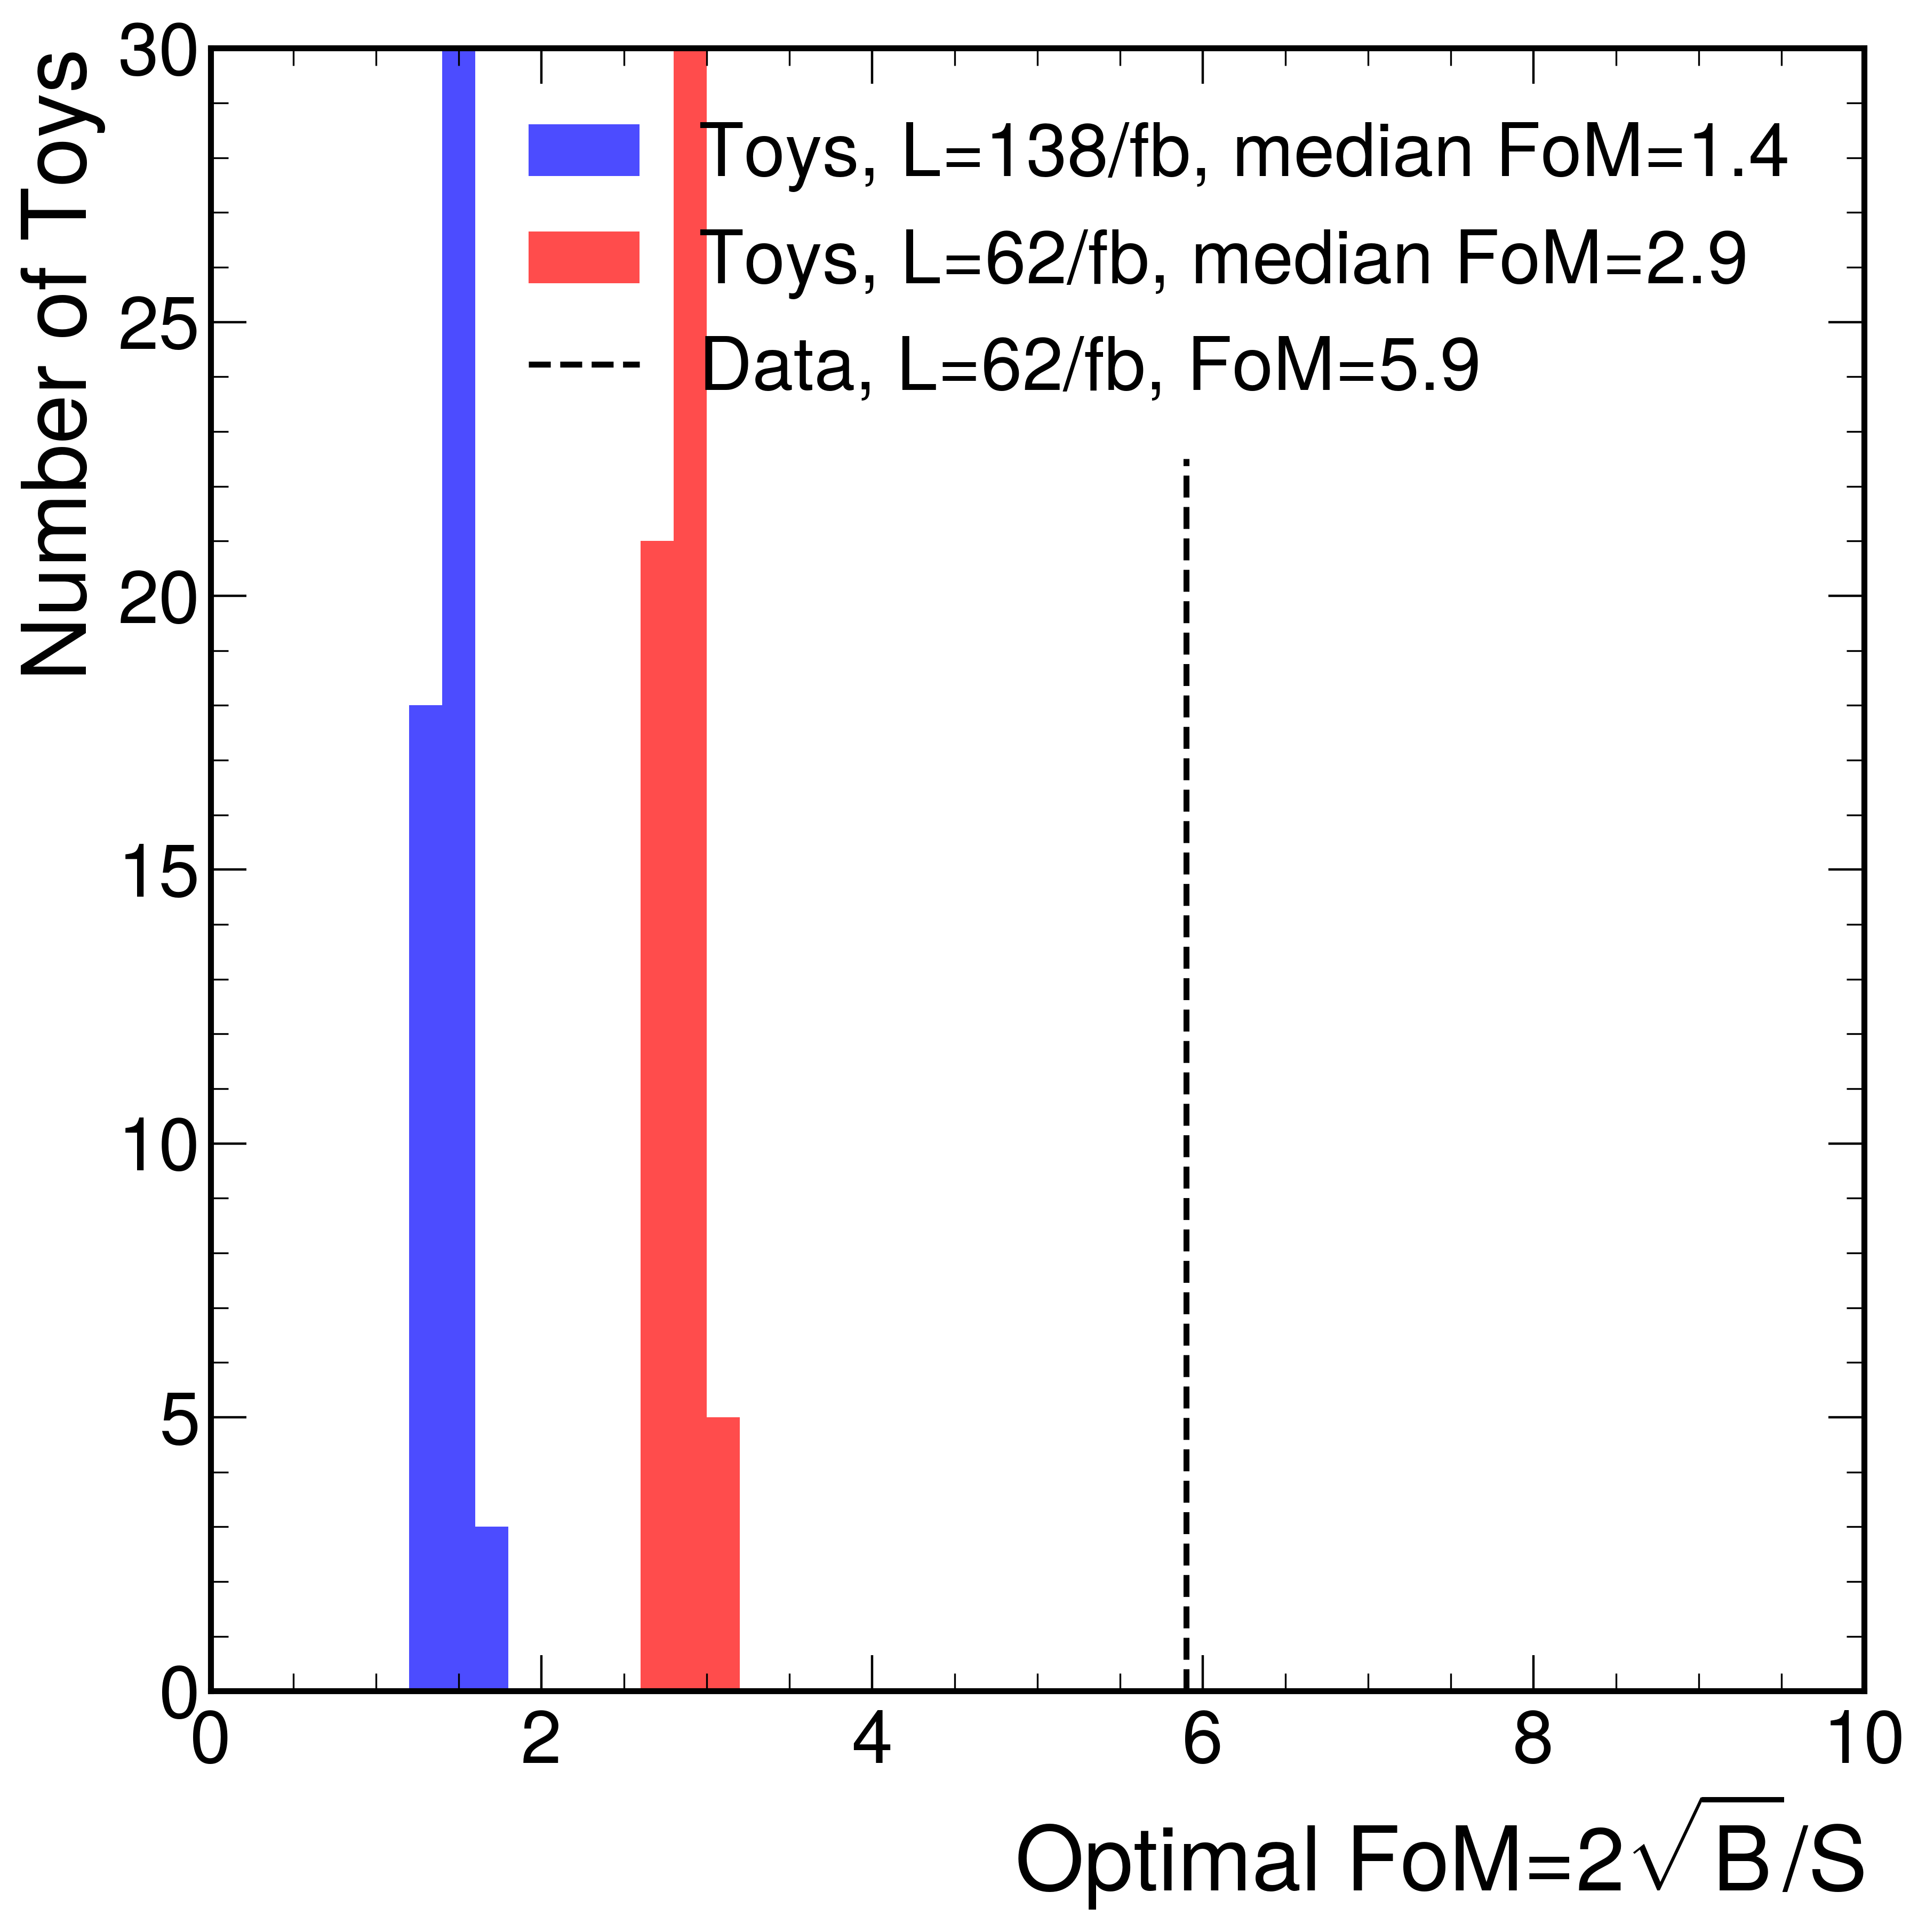

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(
    fom_toys,
    bins=np.linspace(0, 10, 51),
    alpha=0.7,
    label=f"Toys, L=138/fb, median FoM={np.median(fom_toys):.1f}",
    color="blue",
)
plt.hist(
    fom_toys_ls1,
    bins=np.linspace(0, 10, 51),
    alpha=0.7,
    label=f"Toys, L=62/fb, median FoM={np.median(fom_toys_ls1):.1f}",
    color="red",
)
plt.axvline(
    global_min,
    ymin=0,
    ymax=0.75,
    color="black",
    linestyle="--",
    label=f"Data, L=62/fb, FoM={global_min:.1f}",
)
plt.xlabel(r"Optimal FoM=$2\sqrt{B}/S$")
plt.ylabel("Number of Toys")
# set x-axis limits
plt.xlim(0, 10)
# get current axes and set y-axis limits
plt.ylim(0, 30)
plt.legend()
plt.show()